<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Prototypical_Networks_in_TensorFlow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data gathering

In [0]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

In [0]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

In [0]:
!unzip images_background.zip

In [0]:
!unzip images_evaluation.zip

In [0]:
from matplotlib import pyplot as plt
from PIL import Image
import multiprocessing as mp
import pandas as pd 
import numpy as np 
import cv2
import os

In [0]:
random_10_bengali = os.listdir('/content/images_background/Bengali/character01/')
random_10_bengali

['0132_16.png',
 '0132_01.png',
 '0132_12.png',
 '0132_17.png',
 '0132_08.png',
 '0132_15.png',
 '0132_18.png',
 '0132_19.png',
 '0132_04.png',
 '0132_06.png',
 '0132_07.png',
 '0132_11.png',
 '0132_03.png',
 '0132_10.png',
 '0132_09.png',
 '0132_14.png',
 '0132_05.png',
 '0132_13.png',
 '0132_20.png',
 '0132_02.png']

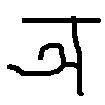

In [0]:
Image.open('/content/images_background/Bengali/character01/0132_01.png')

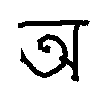

In [0]:
Image.open('/content/images_background/Bengali/character01/0132_10.png')

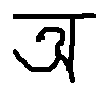

In [0]:
Image.open('/content/images_background/Bengali/character01/0132_02.png')

## Data reading and augmentation
The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Then to increase the number of classes, all the images are rotated by 90, 180 and 270 degrees and each rotation resulted in one more class. Hence the total count of classes reached to 6492(1623 * 4) classes. We split images of 4200 classes to training data and the rest went to test set.

In [0]:
train_dir = os.listdir('images_background/')
datax = np.array([])

In [0]:
def image_rotate(img, angle):
    """
    Image rotation at certain angle. It is used for data augmentation 
    """
    rows,cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2 ,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return np.expand_dims(dst, 0)

In [0]:
def read_alphabets(alphabet_directory, directory):
    """
    Reads all the characters from alphabet_directory and augment each image with 90, 180, 270 degrees of rotation.
    """
    datax = None
    datay = []
    characters = os.listdir(alphabet_directory)
    for character in characters:
        images = os.listdir(alphabet_directory + character + '/')
        for img in images:
            image = cv2.resize(cv2.imread(alphabet_directory + character + '/' + img), (28,28))
            image90 = image_rotate(image, 90)
            image180 = image_rotate(image, 180)
            image270 = image_rotate(image, 270)
            image = np.expand_dims(image, 0)
            if datax is None:
                datax = np.vstack([image, image90, image180, image270])
            else:
                datax = np.vstack([datax, image, image90, image180, image270])
            datay.append(directory + '_' + character + '_0')
            datay.append(directory + '_' + character + '_90')
            datay.append(directory + '_' + character + '_180')
            datay.append(directory + '_' + character + '_270')
    return datax, np.array(datay)

In [0]:
def read_images(base_directory):
    """
    Used multithreading for data reading to decrease the reading time drastically
    """
    datax = None
    datay = []
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets, args=(base_directory + '/' + directory + '/', directory, )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [0]:
%time trainx, trainy = read_images('images_background/')

CPU times: user 1.08 s, sys: 613 ms, total: 1.69 s
Wall time: 15.5 s


In [0]:
%time testx, testy = read_images('images_evaluation/')

CPU times: user 516 ms, sys: 321 ms, total: 838 ms
Wall time: 10.5 s


In [0]:
assert(trainx.shape[0] == trainy.shape[0])
assert(testx.shape[0] == testy.shape[0])

In [0]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

## Building the network in TensorFlow 2.0 using `tf.keras`

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import pairwise_distances
from tensorflow import keras

In [0]:
conv_block = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2,2))
])                       

In [0]:
flatten_layer = tf.keras.layers.Flatten()

In [0]:
def get_embeddings(support_set):
    x = conv_block(support_set)
    x = conv_block()
    x = conv_block()
    x = conv_block()
    return flatten_layer(x)

In [0]:
class Net(keras.Model):
    """
    Image2Vector CNN which takes image of dimension (28x28x3) and return column vector length 64
    """
    def sub_block(self, out_channels=64, kernel_size=(3,3)):
        block = keras.models.Sequential([
                    keras.layers.Conv2D(filters=out_channels, \
                        kernel_size=kernel_size, input_shape=(28, 28, 3)),
                    keras.layers.BatchNormalization(),
                    keras.layers.ReLU(),
                    keras.layers.MaxPool2D(pool_size=(2,2))
        ])
        return block
    
    def __init__(self):
        super(Net, self).__init__()
        self.convnet1 = self.sub_block()
        self.convnet2 = self.sub_block()
        self.convnet3 = self.sub_block()
        self.convnet4 = self.sub_block()

    def call(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.convnet4(x)
        x = keras.layers.Flatten()(x)
        return x

To be continued.

https://blog.floydhub.com/n-shot-learning/